# DeepAtlas

https://arxiv.org/abs/1904.08465

In [1]:
import monai
import torch
import glob
import os.path
import numpy as np
import random
import matplotlib.pyplot as plt

# Loading OASIS images

See [fact sheet here](https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf) for info on OASIS-1 dataset. Get [data here](https://www.oasis-brains.org/#data).

## Filepaths

We already have a segmentaton for each image. These segmentations were originally done by an algorithm:

*Segmentation of brain MR images through a hidden Markov random field model and the expectation maximization algorithm*\
2001 Zhang, Brady, Smith\
[link](https://pubmed.ncbi.nlm.nih.gov/11293691/)

The situation in which we'd want to apply DeepAtlas is one where we have just a handful of carefully created manual segmengations. We will simulate this situation by pretending that some of the segmentation labels don't exist, and ignoring the fact that the segmentations we have come from an algorithm.

In [2]:
oasis_dir = "/data/ebrahim-data/OASIS-1/"
image_paths = glob.glob(os.path.join(oasis_dir,'*/PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img'))
segmentation_paths = glob.glob(os.path.join(oasis_dir,'*/FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img'))

In [3]:
path_to_id = lambda path : os.path.basename(path).strip('OAS1_')[:4]

seg_ids = list(map(path_to_id, segmentation_paths))
img_ids = map(path_to_id, image_paths)
data = []
for img_index,img_id in enumerate(img_ids):
    seg_index = seg_ids.index(img_id) if (img_id in seg_ids) else None
    seg_path = segmentation_paths[seg_index] if (seg_index is not None) else None
    img_path = image_paths[img_index]
    data.append(
        {
            'img' : img_path,
             'seg' : seg_path
        }
    )

We pretend that only a few segmentations are available.
For all but a few items in `data`, we remove the `seg` key.

Having partially available keys can be handled nicely by transforms
if we set `allow_missing_keys=True` in the transform parameters.
That will come up later when we set up transforms.

In [4]:
num_segs_to_select = 17
random.shuffle(data)
for image_label_dict in data[:(len(data)-num_segs_to_select)]:
    image_label_dict.pop('seg')
random.shuffle(data)

In [5]:
def preview_image(image_array):
    x,y,z = np.array(image_array.shape)//2 # half-way slices
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1); plt.axis('off')
    plt.imshow(image_array[x,:,:], origin = 'lower')
    plt.subplot(1,3,2); plt.axis('off')
    plt.imshow(image_array[:,y,:], origin = 'lower')
    plt.subplot(1,3,3); plt.axis('off')
    plt.imshow(image_array[:,:,z], origin = 'lower')
    plt.show()

# Uncomment the following to preview a random image
# preview_image(monai.transforms.LoadImage(image_only=True, reader='itkreader')(random.choice(data)['img']))

## Datasets for segmentation network pretraining

In the DeepAtlas framework, one jointly or alternatively trains a registration network and a segmentation network. It is recommended that the segmentation network be pre-trained first, using whatever little segmentation is available.

We select the subset of `data` that has segmentation labels available, and then split that into a training and a validation set. 

In [6]:
data_seg_available  =  list(filter(lambda d : 'seg' in d.keys() ,data))
data_seg_unavailable = list(filter(lambda d : 'seg' not in d.keys() ,data))

data_seg_available_train, data_seg_available_valid = \
    monai.data.utils.partition_dataset(data_seg_available, ratios=(8,2))
# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. you should definitely skip validation here if there's just one segmentation label.

Now we set up the chain of transforms that will be used to load images and segmentations for the pre-training of the segmentation network.

In [20]:
transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img','seg'], image_only=True),
        monai.transforms.ToTensorD(keys=['img','seg']),
        monai.transforms.TransposeD(keys = ['img', 'seg'], indices = (2,1,0)),
        monai.transforms.AddChannelD(keys=['img','seg'])
    ]
)



# Supress the many warnings related to depracation of the Analyze file format
# (without this, we would see warnings when the LoadImage transform calls itk to load Analyze files)
import itk
itk.ProcessObject.SetGlobalWarningDisplay(False)

# "Initializing" ITK by using it a little as in following line
# seems to be necessary to get CacheDataset below to work on the first run.
# Related discussion:
#   https://discourse.itk.org/t/attributeerror-module-itk-itkclassifierspython-has-no-attribute-swig/3168
itk.array_from_image(itk.imread(random.choice(data)['img']));

# Uncomment the following line to preview a random image with the transform above applied
# preview_image(transform_seg_available(random.choice(data_seg_available))['img'][0])

And now we define the datasets that use those transforms to load the data. We use `CacheDataset` to take advantage of MONAI's caching. 

In [21]:
dataset_seg_available_train = monai.data.CacheDataset(
    data = data_seg_available_train,
    transform = transform_seg_available,
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data = data_seg_available_valid,
    transform = transform_seg_available,
)

Loading dataset: 100%|██████████| 3/3 [00:00<00:00, 77.40it/s]


## Datasets for training both

For the joint/alternative training of the registration and segmentation networks, we want to load _pairs_ of images, along with their segmentation labels when those are available. We create data lists for pairs of images, after reserving some images for validation of the registration network.

In [23]:
# Be careful not to include any images with segmentation label that were used for seg_net validation.
# We don't want those influencing further seg_net training that occurs after pre-training
data_without_seg_valid = data_seg_unavailable + data_seg_available_train # Note the order

# For validation of reg_net, we prefer not to use the precious data_seg_available_train,
# if that's possible. The following split tries to use data_seg_unavailable for the
# the validation set, to the extent possible.
data_valid, data_train = monai.data.utils.partition_dataset(
    data_without_seg_valid, # Note the order
    ratios=(2,8), # Note the order
    shuffle = False
)

def take_data_pairs(data):
    """Given a list of dicts that have keys for an image and possibly a segmentation,
    return a list of dicts corresponding to *pairs* of images and possible segmentations.
    Pairs consisting of a repeated image are not included, and only one ordering is
    included between a pair and its reverse."""
    data_pairs = []
    for i in range(len(data)):
        # We will not allow reverse pairs, since we plan to handle both "directions" in each training step
        # (this allows us to introduce inverse consistency loss, if we want to)
        for j in range(i):
            d1 = data[i]
            d2 = data[j]
            pair = {
                'img1' : d1['img'],
                'img2' : d2['img']
            }
            if 'seg' in d1.keys():
                pair['seg1'] = d1['seg']
            if 'seg' in d2.keys():
                pair['seg2'] = d2['seg']
            data_pairs.append(pair)
    return data_pairs

data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

For the sake of being able to fit everything into graphics memory, we will choose to train the registration and segmentation networks in _alternation_ rather than jointly. When we are doing this we will want a way to load only image pairs that will contribute to segmentation network training-- i.e. image pairs for which at least one of them has a segmentation label available. We create a data list for this purpose.

In [24]:
data_pairs_train_seg_trainable = list(filter(lambda d : 'seg1' in d or 'seg2' in d.keys() ,data_pairs_train))

In [25]:
print(f"""We have {len(data_pairs_train_seg_trainable)} pairs to train reg_net and seg_net together,
  and an additional {len(data_pairs_train) - len(data_pairs_train_seg_trainable)} to train reg_net alone.""")
print(f"We have {len(data_pairs_valid)} pairs for reg_net validation.")

We have 4725 pairs to train reg_net and seg_net together,
  and an additional 54615 to train reg_net alone.
We have 3655 pairs for reg_net validation.


Now we set up the chain of transforms that will be used for loading image pairs.

We will concatenate the "fixed" and "moving" images along the channel dimension.

In [28]:
transform_pair = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=['img1','seg1', 'img2', 'seg2'], image_only=True,allow_missing_keys=True),
        monai.transforms.ToTensorD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.TransposeD(keys = ['img1','seg1', 'img2', 'seg2'], indices = (2,1,0), allow_missing_keys=True),
        monai.transforms.AddChannelD(keys=['img1','seg1', 'img2', 'seg2'], allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=['img1', 'img2'], name='img12', dim=0),
        monai.transforms.DeleteItemsD(keys=['img1', 'img2'])
    ]
)

And now we define the datasets that use the transforms to load the data. Again we use `CacheDataset` to take advantage of MONAI's caching.

In [29]:
dataset_pairs_train = monai.data.CacheDataset(
    data = data_pairs_train,
    transform = transform_pair,
    cache_num=8
)

dataset_pairs_valid = monai.data.CacheDataset(
    data = data_pairs_valid,
    transform = transform_pair,
    cache_num=8
)

dataset_pairs_train_seg_trainable = monai.data.CacheDataset(
    data = data_pairs_train_seg_trainable,
    transform = transform_pair,
    cache_num=8
)

Loading dataset: 100%|██████████| 8/8 [00:00<00:00, 33.59it/s]


# Defining networks and losses


## Segmentation network

In [30]:
# It's not the same as the paper, since the paper does maxpooling for it's seg net,
# while this UNet does convolution with stride>1 for the downsampling steps.
# Also the paper uses leaky relu activation and this uses prelu.
# Also the paper does batch norm while this does instance norm

seg_net = monai.networks.nets.UNet(
    3, # spatial dims
    1, # input channels
    4, # output channels (4 segmentation classes)
    (8,16,16,32,32,64,64), # channel sequence
    (1,2,1,2,1,2) # convolutional strides
)

In [31]:
# Try out a forward pass

# It's pretty fortunate that the OASIS images have all their spatial dimensions being multiples of 8,
# cosnidering that we downsample by a factor of 2 three time in the UNet. Very clean.

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item['img'].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg'])}")
print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}") 

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 176, 208, 176])
Shape of seg_net output: torch.Size([1, 4, 176, 208, 176])


## Dice loss for segmentations

In [32]:
dice_loss = monai.losses.DiceLoss(
    include_background=True, # Include background in the multiclass DICE loss: background, CSF, grey, white
    to_onehot_y=True, # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True, # Note that our segmentation network is missing the softmax at the end
    reduction="mean" # Follows the paper
)

# A version of the dice loss with to_onehot_y=False;
# will be handy for anatomy loss, for which we often compare two outputs of seg_net
dice_loss2 = monai.losses.DiceLoss(
    include_background=True, # Include background in the multiclass DICE loss: background, CSF, grey, white
    to_onehot_y=False, # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True, # Note that our segmentation network is missing the softmax at the end
    reduction="mean" # Follows the paper
)

In [36]:
# Uncomment to try out the dice loss on the example.

# dice_loss(
#     seg_net_example_output, # Prediction from seg_net
#     data_item['seg'].unsqueeze(0) # Ground truth label
# )

## Registration network

In [37]:
# Not exactly identical to the registration network in the paper, but similar
# The main difference is that this one doesn't get to the very middle step labeled 1/16
# It seems that MONAI UNet design will not stick one block in the middle like we see in fig 3 of the paper

reg_net = monai.networks.nets.UNet(
    3, # spatial dims
    2, # input channels (one for fixed image and one for moving image)
    3, # output channels (to represent 3D displacement vector field)
    (16,32,32,32,32), # channel sequence
    (1,2,2,2) # convolutional strides
)

In [38]:
# Try out a forward pass

data_item = random.choice(dataset_pairs_train_seg_trainable)

reg_net_example_output = reg_net(data_item['img12'].unsqueeze(0))
print(f"Shape of reg_net output: {reg_net_example_output.shape}") 
# The output of the reg_net is assumed to be a displacement vector field
# (so e.g. a zero output would be the identity warping)

Shape of reg_net output: torch.Size([1, 3, 176, 208, 176])


In [39]:
warp = monai.networks.blocks.Warp()

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item['img12'][[1],:,:,:].unsqueeze(0), # moving image
    reg_net_example_output # warping
)

# Uncomment to preview warped image from forward pass example above
# preview_image(example_warped_image[0,0].detach())

monai.networks.blocks.Warp: Using PyTorch native grid_sample.
torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)


In [42]:
# Preview deformation as a vector field plot

def plot_2D_vector_field(vector_field, downsampling):
    """Vector_field should be a tensor of shape (2,L,W).
    The 0 dimension is the two components of the output vectors"""
    downsample2D = monai.networks.layers.factories.Pool['AVG',2](kernel_size=downsampling)
    vf_downsampled = downsample2D(vector_field.unsqueeze(0))[0]
    plt.quiver(vf_downsampled[0,:,:], vf_downsampled[1,:,:]);
    

def preview_3D_vector_field(vector_field):
    """Vector_field should be a tensor of shape (3,L,W,H).
    The 0 dimension is the three components of the output vectors"""
    
    x,y,z = np.array(vector_field.shape[1:])//2 # half-way slices
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.axis('off')
    plot_2D_vector_field(vector_field[[1,2],x,:,:], 4)
    plt.subplot(1,3,2); plt.axis('off')
    plot_2D_vector_field(vector_field[[0,2],:,y,:], 4)
    plt.subplot(1,3,3); plt.axis('off')
    plot_2D_vector_field(vector_field[[0,1],:,:,z], 4)
    plt.show()

# Uncomment to preview displacement field from example forward pass of reg_net above
# preview_3D_vector_field(reg_net_example_output.detach()[0])

## Image similarity loss

In [43]:
# Local normalized cross-correlation loss.
# The paper does a global NCC, but MONAI provides local and it's easy to use.
# Another difference from the paper: instead of returning 1-LNCC this will return -LNCC

lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    ndim=3, # this keyword argument will soon be renamed to spatial_dims
    kernel_size=3,
    kernel_type='rectangular',
    reduction="mean"
)

In [46]:
# Uncomment to try out the image similarity loss on the example.

# lncc_loss(
#     example_warped_image, # registered image
#     data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
# )

## Regularization loss for registration

In [47]:
bending_loss = monai.losses.BendingEnergyLoss()

# Uncomment to try out the bending energy loss on the example
# bending_loss(reg_net_example_output)

# Segmentation network pre-training

training loss: 0.7682797525610242, validation loss: 0.7354772686958313


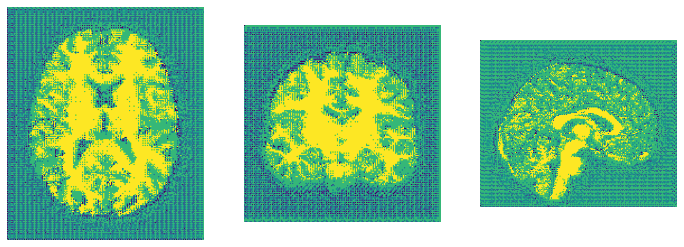

training loss: 0.7060320930821555, validation loss: 0.6769651571909586


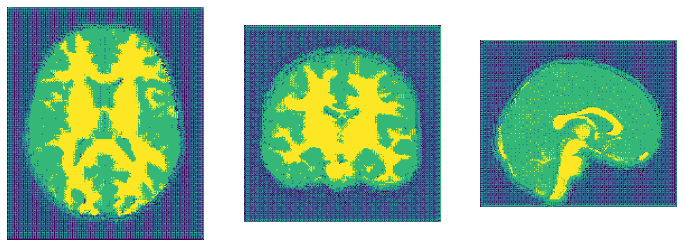

training loss: 0.653416131223951, validation loss: 0.6271355946858724


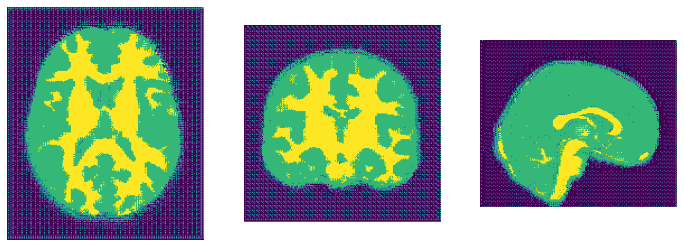

training loss: 0.6031161802155631, validation loss: 0.5760251879692078


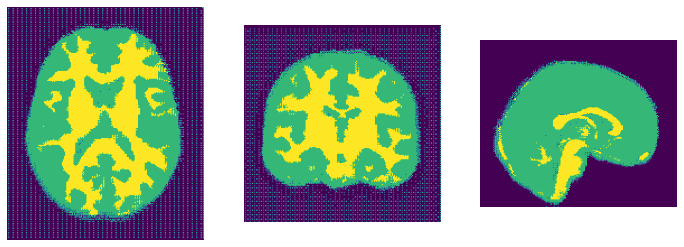

training loss: 0.5512702209608895, validation loss: 0.5242327253023783


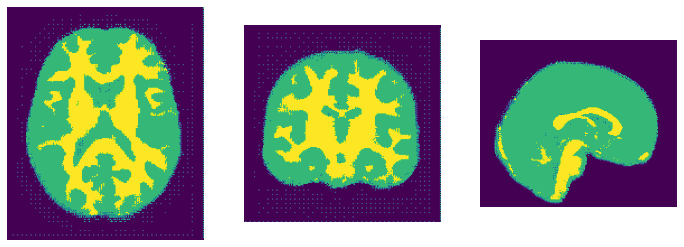

training loss: 0.4987033222402845, validation loss: 0.4710834324359894


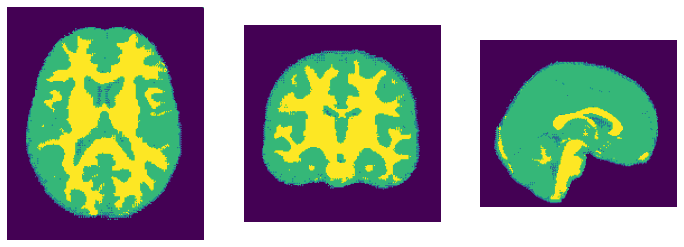

training loss: 0.4453078423227583, validation loss: 0.41949435075124103


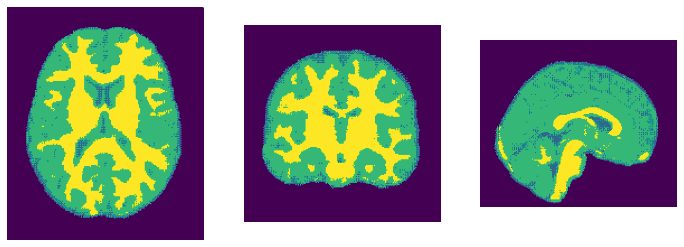

training loss: 0.3948280896459307, validation loss: 0.3733082214991252


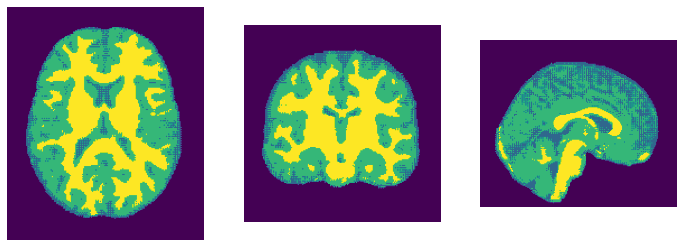

training loss: 0.35172587420259205, validation loss: 0.33346027135849


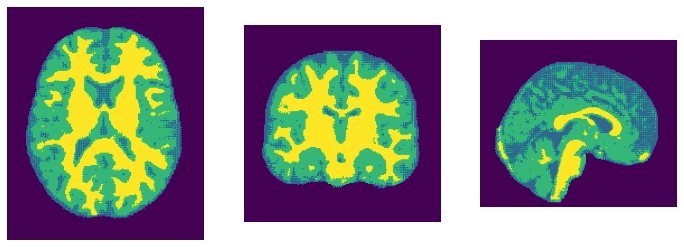

training loss: 0.31347346944468363, validation loss: 0.29823945959409076


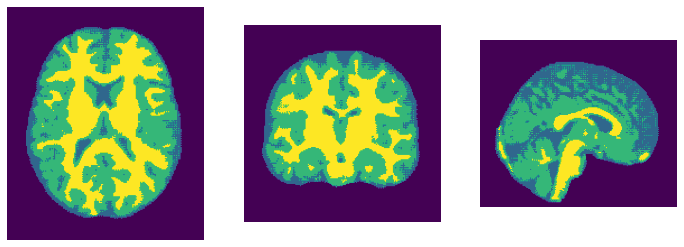

training loss: 0.28103333711624146, validation loss: 0.27133216460545856


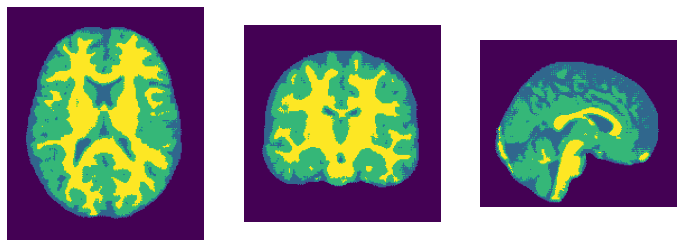

training loss: 0.25404671473162516, validation loss: 0.24742767214775085


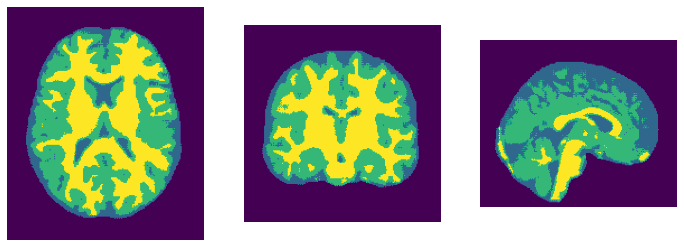

training loss: 0.2324476901973997, validation loss: 0.2266594966252645


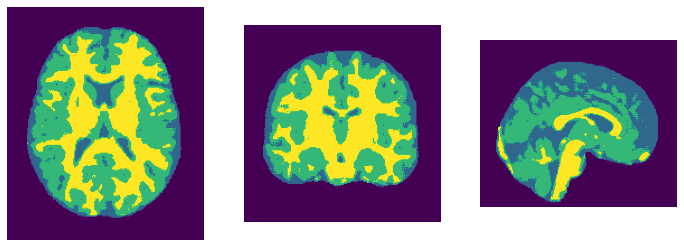

training loss: 0.21454777249268123, validation loss: 0.21224535008271536


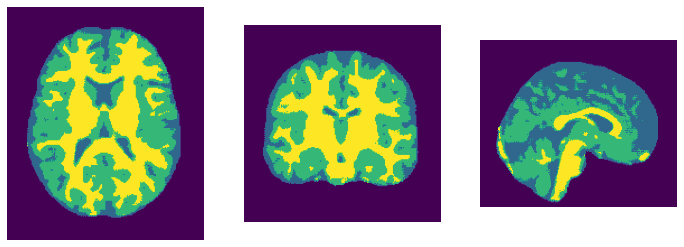

training loss: 0.20232335052319936, validation loss: 0.1989174485206604


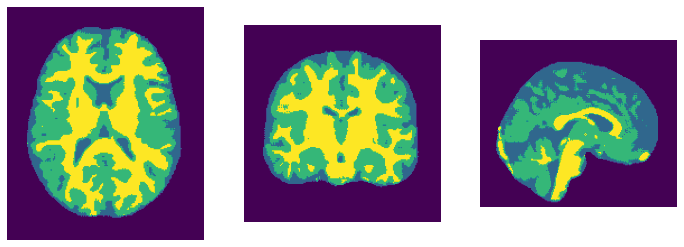

training loss: 0.1913999148777553, validation loss: 0.18882364531358084


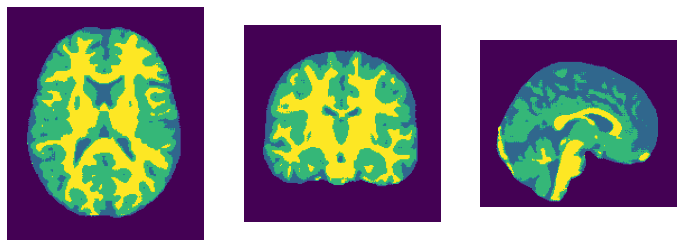

training loss: 0.1802764588168689, validation loss: 0.18339771529038748


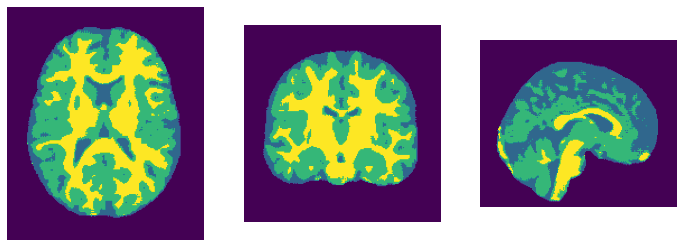

training loss: 0.17288910916873387, validation loss: 0.17412748436133066


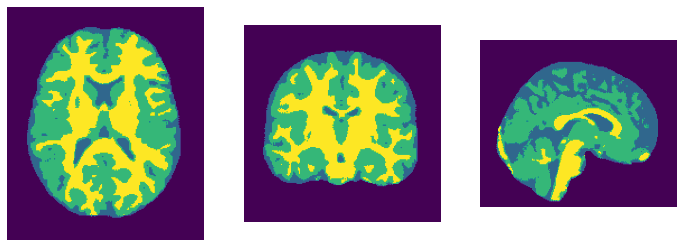

training loss: 0.1643738214458738, validation loss: 0.16495840748151144


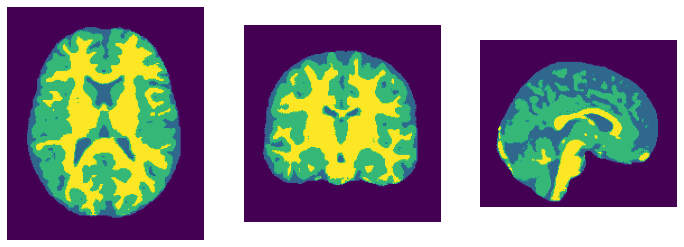

training loss: 0.15710984276873724, validation loss: 0.15925251444180807


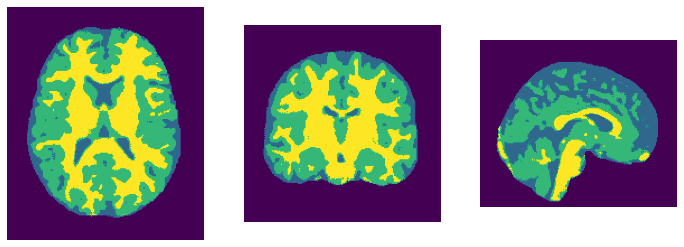

training loss: 0.15132010408810206, validation loss: 0.15624246497948965


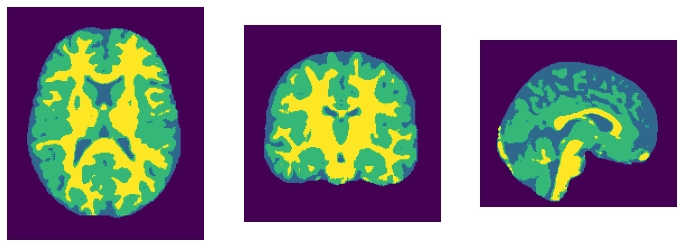

training loss: 0.14551158675125667, validation loss: 0.14918110768000284


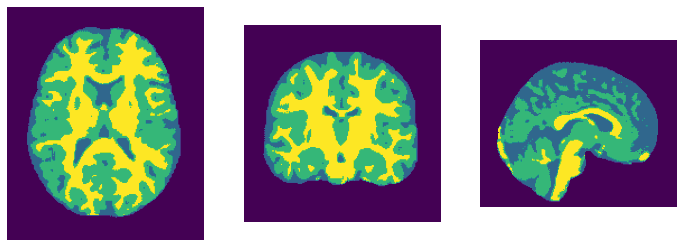

training loss: 0.14047446101903915, validation loss: 0.14271737138430277


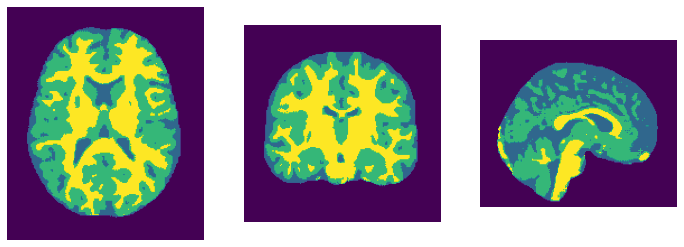

training loss: 0.1368938216141292, validation loss: 0.14093662798404694


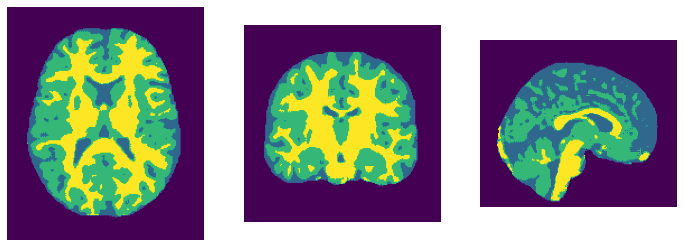

training loss: 0.13322793798787252, validation loss: 0.13762074212233225


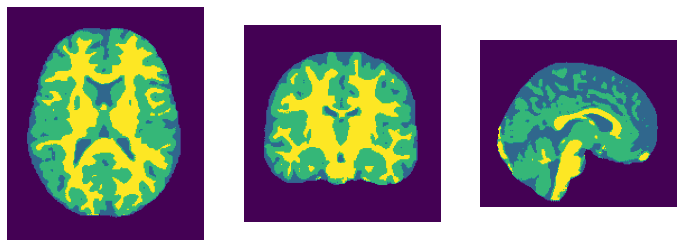

training loss: 0.12807905886854445, validation loss: 0.13269599278767905


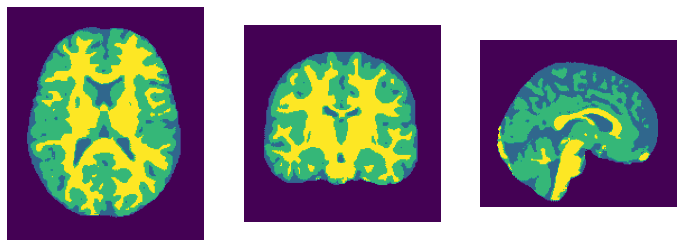

training loss: 0.12377143970557622, validation loss: 0.13213922580083212


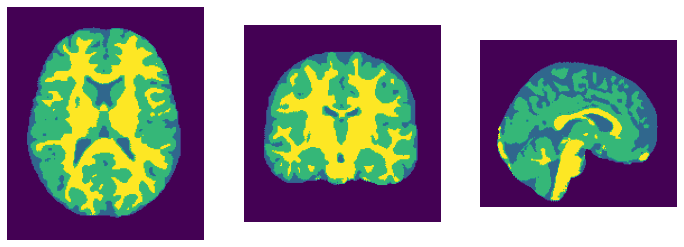

training loss: 0.12303851970604487, validation loss: 0.13353547950585684


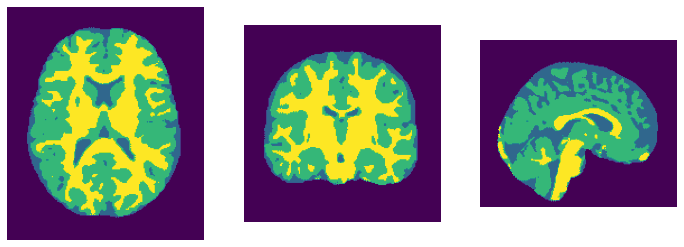

training loss: 0.12019679482494082, validation loss: 0.1288223514954249


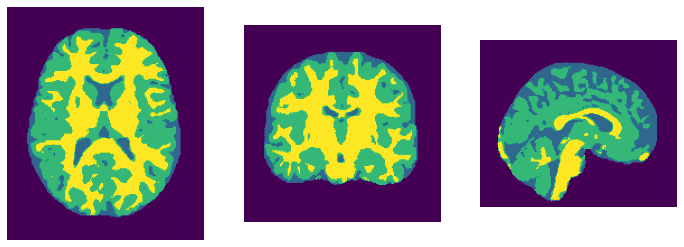

training loss: 0.11699892580509186, validation loss: 0.12697074810663858


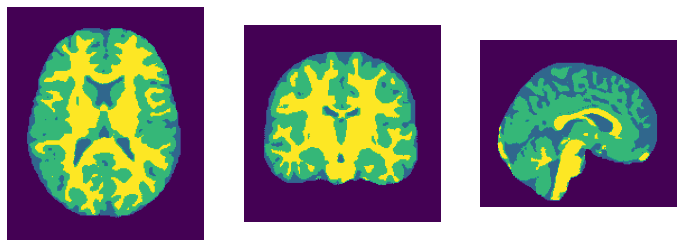

In [48]:
# Training cell, uncomment when you want to train

# seg_net.to('cuda')

# dataloader_seg_available_train = monai.data.DataLoader(
#     dataset_seg_available_train,
#     batch_size=1,
#     num_workers=4,
#     shuffle=True
# )

# dataloader_seg_available_valid = monai.data.DataLoader(
#     dataset_seg_available_valid,
#     batch_size=1,
#     num_workers=4,
#     shuffle=False
# )

# learning_rate = 1e-4
# optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)

# max_epochs = 30
# training_losses = []
# validation_losses = []

# for epoch_number in range(max_epochs):
    
    
#     seg_net.train()
#     losses = []
#     for batch in dataloader_seg_available_train:
#         imgs = batch['img'].to('cuda')
#         true_segs = batch['seg'].to('cuda')

#         optimizer.zero_grad()
#         predicted_segs = seg_net(imgs)
#         loss = dice_loss(predicted_segs, true_segs)
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.item())
    
#     training_loss = np.mean(losses)
    
#     seg_net.eval()
#     losses = []
#     with torch.no_grad():
#         for batch in dataloader_seg_available_valid:
#             imgs = batch['img'].to('cuda')
#             true_segs = batch['seg'].to('cuda')
#             predicted_segs = seg_net(imgs)
#             loss = dice_loss(predicted_segs, true_segs)
#             losses.append(loss.item())
#         validation_loss = np.mean(losses)
        
#     print(f"training loss: {training_loss}, validation loss: {validation_loss}")
#     preview_image(torch.argmax(torch.softmax(seg_net(dataset_seg_available_valid[0]['img'].unsqueeze(0).cuda()),dim=1),dim=1, keepdim=True)[0,0].cpu())
    
#     training_losses.append(training_loss)
#     validation_losses.append(validation_loss)

# # Clean up to keep cuda memory usage under control
# del loss, predicted_segs, true_segs, imgs
# torch.cuda.empty_cache()

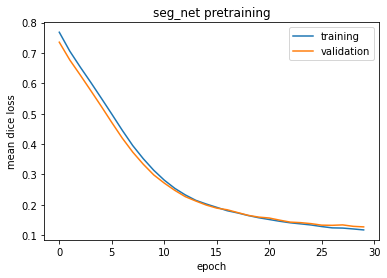

In [49]:
# Plot the training and validation losses

# plt.plot(training_losses, label="training")
# plt.plot(validation_losses, label="validation")
# plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('mean dice loss')
# plt.title('seg_net pretraining')
# plt.savefig('seg_net_pretrained_losses.png')
# plt.show()

In [52]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net_pretrained.pth')

In [68]:
# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net_pretrained.pth'))

<All keys matched successfully>

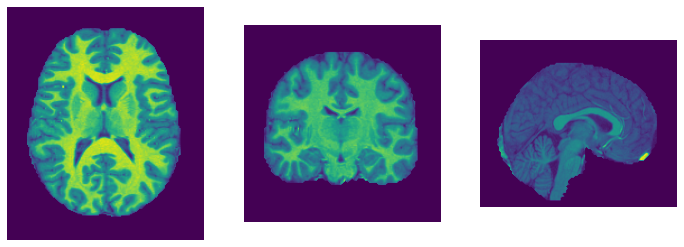

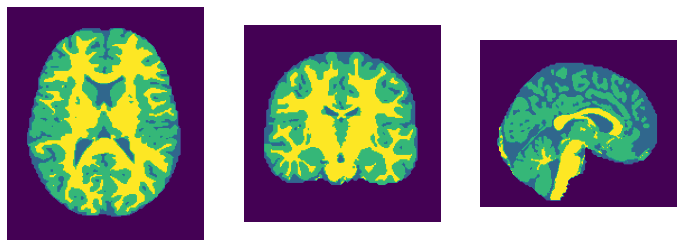

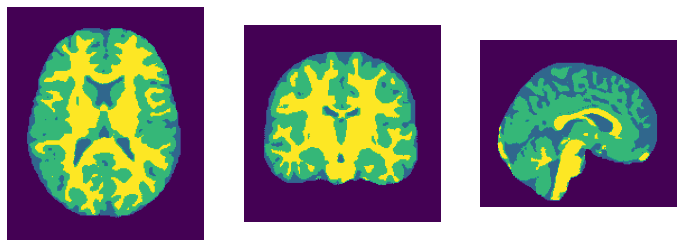

In [82]:
# Uncomment to try out pretrained seg net on one of the validation images

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item['img']
test_seg_true = data_item['seg']
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

# Original image from validation set
preview_image(test_input[0])
# Ground truth segmentation
preview_image(test_seg_true[0])
# Our predicted segmentation
preview_image(torch.argmax(torch.softmax(test_seg_predicted,dim=1),dim=1, keepdim=True)[0,0])

del test_seg_predicted
torch.cuda.empty_cache()

# Training both in alternation

In [74]:
def swap_training(network_to_train, network_to_not_train):
    """
        Switch out of training one network and into training another
    """

    for param in network_to_not_train.parameters():
        param.requires_grad = False
    
    for param in network_to_train.parameters():
        param.requires_grad = True
        
    network_to_not_train.eval()
    network_to_train.train()

In [112]:
# Training cell, uncomment when you want to train

seg_net.to('cuda')
reg_net.to('cuda')

dataloader_pairs_train = monai.data.DataLoader(
    dataset_pairs_train,
    batch_size=1,
    num_workers=1,
    shuffle=True
)

dataloader_pairs_valid = monai.data.DataLoader(
    dataset_pairs_valid,
    batch_size=1,
    num_workers=1,
    shuffle=True # Weird to shuffle validation data, but makes sense if you just take a small sample each time
                 # (which I've been doing because it would take way too long to go through all validation pairs)
)

dataloader_pairs_train_seg_trainable = monai.data.DataLoader(
    dataset_pairs_train_seg_trainable,
    batch_size=1,
    num_workers=1,
    shuffle=True
) # TODO still need to use this; when seg-only part of alternation comes up


# TODO: Right now I'm training reg_net only.
# Eventually what I'm doing below should be moved into one step of an alternating system
# Or maybe just switch at the end of each epoch, IDK.
# Epochs are massive anyway, so something needs to be done there.
# Even doing one full epoch is unreasonable.



learning_rate = 5e-4
optimizer = torch.optim.Adam(reg_net.parameters(), learning_rate)

# Weights of various registration losses, relative to the image similarity loss
lambda_r = 0.1 # regularization loss weight
lambda_a = 3.0 # anatomy loss weight


max_epochs = 10
training_batches_per_epoch = 20
num_validation_batches_to_use = 20
training_losses = []
validation_losses = []

# Switch to training reg_net
swap_training(reg_net, seg_net)

for epoch_number in range(max_epochs):
    
    reg_net.train()
    losses = []
    batch_number = 0;
    for batch in dataloader_pairs_train:
        if batch_number > training_batches_per_epoch : break; # TODO remove this early stopper
        img12 = batch['img12'].to('cuda')
#         img21 = img12[:,[1,0],:,:,:] # Use this when ready to introduce inverse consistency loss

        optimizer.zero_grad()
        displacement_fields = reg_net(img12)
        warped_img2 = warp(img12[:,[1],:,:,:], displacement_fields)  
        
        loss_similarity = lncc_loss(
            warped_img2, # prediction
            img12[:,[0],:,:,:] # target
        )
        
        loss_regularization = bending_loss(displacement_fields)
        
        loss_anatomy = dice_loss2(
            warp(seg_net(img12[:,[1],:,:,:]), displacement_fields), # warp of seg_net on moving image
            seg_net(img12[:,[0],:,:,:]) # seg_net on target image, "noisy ground truth"
        )
        
        loss = loss_similarity + lambda_r * loss_regularization + lambda_a * loss_anatomy
        loss.backward()
        optimizer.step()

#         print(f"Epoch {epoch_number+1}/{max_epochs}, batch {batch_number+1}/{len(dataset_pairs_train)}. Loss: {loss.item()}")
        losses.append(loss.item())
        batch_number += 1
    
    training_loss = np.mean(losses)
    
    
    
    reg_net.eval()
    losses = []
    with torch.no_grad():
        batch_number = 0
        for batch in dataloader_pairs_valid:
            if batch_number > num_validation_batches_to_use: break
            img12 = batch['img12'].to('cuda')
            # img21 = img12[:,[1,0],:,:,:]
            displacement_fields = reg_net(img12)
            warped_img2 = warp(img12[:,[1],:,:,:], displacement_fields)
            loss_similarity = lncc_loss(
                warped_img2, # prediciton
                img12[:,[0],:,:,:] # target
            )
            
            losses.append(loss_similarity.item())
            batch_number += 1
        validation_loss = np.mean(losses)
        
    print(f"Epoch {epoch_number+1}/{max_epochs} summary:\n\ttraining loss: {training_loss}\n\tvalidation loss: {validation_loss}")

    training_losses.append(training_loss)
    validation_losses.append(validation_loss)
    
del loss, loss_similarity, loss_regularization, loss_anatomy, warped_img2, displacement_fields, img12
torch.cuda.empty_cache()

Epoch 1/10 summary:
	training loss: 2.9424661624999273
	validation loss: -0.7559250110671634
Epoch 2/10 summary:
	training loss: 1.6484624431246804
	validation loss: -0.8425801935650054
Epoch 3/10 summary:
	training loss: 6.014769713083903
	validation loss: -0.8800380229949951
Epoch 4/10 summary:
	training loss: 5.190460999806722
	validation loss: -0.8974452075504121
Epoch 5/10 summary:
	training loss: 4.148919809432257
	validation loss: -0.9101109249251229
Epoch 6/10 summary:
	training loss: 3.6274976162683394
	validation loss: -0.9189921503975278
Epoch 7/10 summary:
	training loss: 3.402004355476016
	validation loss: -0.9223426495279584
Epoch 8/10 summary:
	training loss: 3.270939690726144
	validation loss: -0.925502754393078
Epoch 9/10 summary:
	training loss: 3.1610541684286937
	validation loss: -0.9282546100162324
Epoch 10/10 summary:
	training loss: 3.0577359199523926
	validation loss: -0.9301692190624419


In [ ]:
# Plot the training and validation losses

# plt.plot(training_losses, label="training")
# plt.plot(validation_losses, label="validation")
# plt.legend()
# plt.xlabel('epoch')
# plt.ylabel('mean dice loss')
# plt.title('seg_net pretraining')
# plt.savefig('reg_net_losses.png')
# plt.show()

In [114]:
# CHECKPOINT CELL; SAVE
# torch.save(seg_net.state_dict(),'seg_net.pth')
# torch.save(reg_net.state_dict(),'reg_net.pth')

In [32]:
# CHECKPOINT CELL; LOAD
seg_net.load_state_dict(torch.load('seg_net.pth'))
reg_net.load_state_dict(torch.load('reg_net.pth'))

<All keys matched successfully>

Shape of reg_net output: torch.Size([1, 3, 176, 208, 176])
moving image:


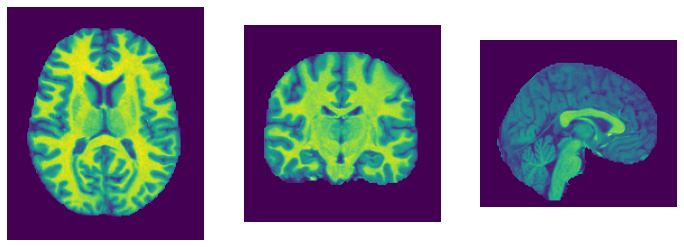

target image:


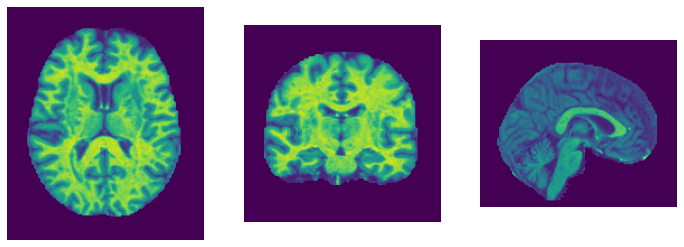

warped moving image:


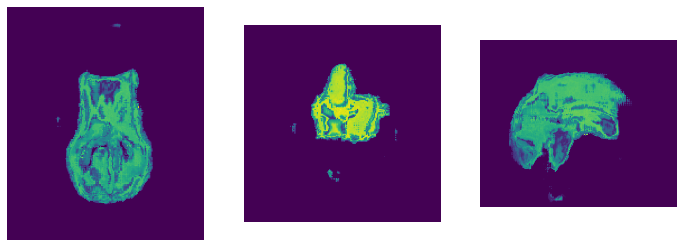

deformation field:


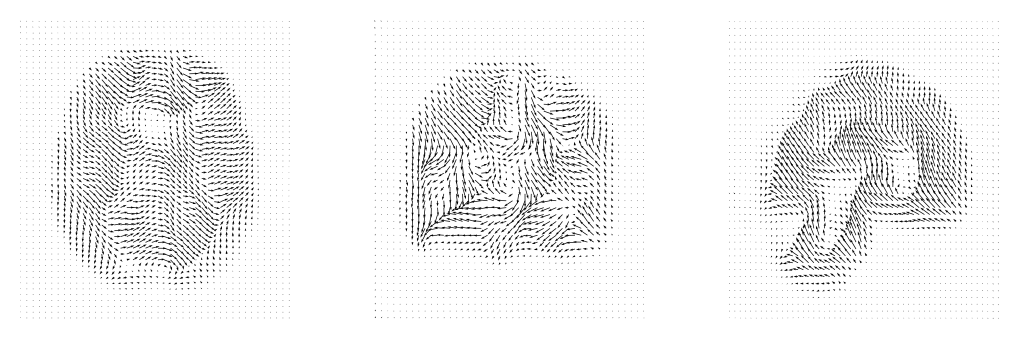

In [115]:
# Uncomment to try out reg net on one of the validation pairs

reg_net.to('cuda')
reg_net.eval()

data_item = random.choice(dataset_pairs_valid)
img12 = data_item['img12'].unsqueeze(0).to('cuda')

with torch.no_grad():
    reg_net_example_output = reg_net(img12)
print(f"Shape of reg_net output: {reg_net_example_output.shape}") 

example_warped_image = warp(
    img12[:,[1],:,:,:], # moving image
    reg_net_example_output # warping
)

# Uncomment to preview displacement field and warped image
print("moving image:")
preview_image(img12[0,1,:,:,:].cpu())
print("target image:")
preview_image(img12[0,0,:,:,:].cpu())
print("warped moving image:")
preview_image(example_warped_image[0,0].cpu())
print("deformation field:")
preview_3D_vector_field(reg_net_example_output.cpu().detach()[0])

del reg_net_example_output, img12, example_warped_image
torch.cuda.empty_cache()